# DWD Weather Station Data
https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/

In [79]:
import os
import re
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict
from itertools import combinations
from shapely.geometry import Point

<b>Weather Stations in Germany for:</b></br></br>
relative humidity (%)</br>
air pressure at station level (hPa)</br>
air temperature near ground (°C)</br>
air temperature at 2 m (°C)</br>
dew point temperature (°C)</br>

diffuse radiation (J/cm<sup>2</sup>)</br>
global radiation (J/cm<sup>2</sup>)</br>
sunshine duration (hours)</br>

wind direction (degree)</br>
wind velocity (m/s)

In [110]:
directory = 'data'
target_dir = 'data/final'
to_date = '2024-11-25'
from_date = '2023-08-01'

column_names = [
    "Stations_id", "von_datum", "bis_datum", "Stationshoehe",
    "geoBreite", "geoLaenge", "Stationsname", "Bundesland", "Abgabe"
]

# get all station files
station_files = []
for root, dirs, files in os.walk(directory):
    for file in files:
        if 'Stationen' in file:
            station_files.append(os.path.join(root, file))

# read all station files
stations = None
for station in station_files:
    df_station = pd.read_fwf(station, 
                             encoding='latin1',
                             skiprows=2,
                             names=column_names)
    df_station['von_datum'] = pd.to_datetime(df_station['von_datum'], format='%Y%m%d')
    df_station['bis_datum'] = pd.to_datetime(df_station['bis_datum'], format='%Y%m%d')
    df_station.drop(['Abgabe'], axis=1, inplace=True)
    table_name = station.split('/')[1]
    df_station['Table'] = table_name
    if station != None:
        stations = pd.concat([stations, df_station], ignore_index=True)
    else:
        stations = df_station.copy()

In [3]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154 entries, 0 to 1153
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Stations_id    1154 non-null   int64         
 1   von_datum      1154 non-null   datetime64[ns]
 2   bis_datum      1154 non-null   datetime64[ns]
 3   Stationshoehe  1154 non-null   int64         
 4   geoBreite      1154 non-null   float64       
 5   geoLaenge      1154 non-null   float64       
 6   Stationsname   1154 non-null   object        
 7   Bundesland     1154 non-null   object        
 8   Table          1154 non-null   object        
dtypes: datetime64[ns](2), float64(2), int64(2), object(3)
memory usage: 81.3+ KB


In [4]:
for root, dirs, files in os.walk(directory):
    print(f'In {root} are {len(files)} files.')

print('')
print(stations.groupby('Table').size().sort_index(ascending=False))

print('\n It is likely that data is not available for all stations.')

In data are 0 files.
In data/wind are 277 files.
In data/solar are 245 files.
In data/air_temperature are 478 files.

Table
wind               309
solar              325
air_temperature    520
dtype: int64

 It is likely that data is not available for all stations.


In [ ]:
stations.drop(stations[stations.bis_datum < to_date].index, inplace=True)
stations.drop(stations[stations.von_datum > from_date].index, inplace=True)

counts = stations.groupby(['Stations_id']).size().value_counts().sort_index()
table_counts = stations.groupby(['Stations_id', 'Table']).size()

print(f'{len(stations.Stations_id.unique())} unique weather stations \n')

for e, c in enumerate(counts, start=1):
    print(f'{c} stations with values in {e} tables.')

print('\nAbsolute number of stations for:')
stations.groupby('Table').size()

526 unique weather stations 

295 stations with values in 1 tables.
97 stations with values in 2 tables.
134 stations with values in 3 tables.

Absolute number of stations for:


Table
air_temperature    463
solar              163
wind               265
dtype: int64

In [6]:
grouped = stations.groupby(['Stations_id'])['Table'].apply(list)

combination_counts = {}
for categories in grouped:
    for pair in combinations(categories, 2):
        pair = tuple(sorted(pair))
        combination_counts[pair] = combination_counts.get(pair, 0) + 1
    
grouped_counts = stations.groupby(["Stations_id", "Table"]).size().unstack(fill_value=0)
single_entries = grouped_counts[grouped_counts.sum(axis=1) == 1].sum()

categories = ["air_temperature", "solar", "wind"]
matrix = pd.DataFrame(0, index=categories, columns=categories)

for (cat1, cat2), count in combination_counts.items():
    matrix.loc[cat1, cat2] += count
    matrix.loc[cat2, cat1] += count  

for category in categories:
    if category in single_entries:
        matrix.loc[category, category] = single_entries[category]
        
matrix

,air_temperature,solar,wind
air_temperature,232,163,202
solar,163,0,134
wind,202,134,63


In [7]:
valid_stations = (
    stations.groupby("Stations_id")["Table"]
    .apply(lambda x: set(x) == {"air_temperature", "solar", "wind"})
)

valid_stations_ids = valid_stations[valid_stations].index

stations3 = stations[stations["Stations_id"].isin(valid_stations_ids)]

134 unique weather stations after cleaning. 



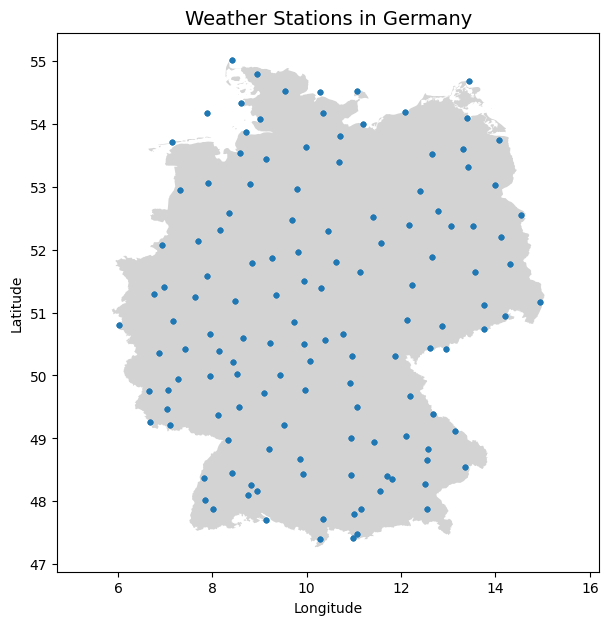

In [8]:
germany = gpd.read_file('geoBoundaries-DE.geojson')

geometry = [Point(xy) for xy in zip(stations3['geoLaenge'], stations3['geoBreite'])]
geo_df = gpd.GeoDataFrame(stations3, geometry=geometry)

print(f'{len(stations3.Stations_id.unique())} unique weather stations after cleaning. \n')

fig, ax = plt.subplots(figsize=(7, 7))
germany.plot(ax=ax, color='lightgrey')  
geo_df.plot(ax=ax, 
            label='Stations', 
            markersize=10, 
            legend=True)

stretch_factor = 0.75 
ax.set_aspect(1 / stretch_factor, adjustable='datalim')

plt.title('Weather Stations in Germany', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [58]:
stations_ids = stations3.Stations_id.unique()

# get list of relevant station files
file_paths = []
for root, dirs, files in os.walk(directory):
    for file in files:
        if 'produkt' in file:
            file_split = re.split(r'[_\.]', file)
            
            to_date_file = datetime.strptime(file_split[5], '%Y%m%d')
            
            in_date = not to_date_file < datetime.strptime(to_date, '%Y-%m-%d')  
            in_ids = int(file_split[-2]) in stations_ids
            
            if in_date and in_ids:
                file_paths.append(os.path.join(root, file))

In [ ]:
# check if the list of files contains all relevant stations
extracted_data = []

for path in file_paths:
    parts = re.split(r'[\/_.]', path) 
    category = parts[1]               
    if category == "air":
        category = "air_temperature"
        date = parts[8]       
        station_id = parts[9] 
    else:
        date = parts[7]       
        station_id = parts[8]
           
    extracted_data.append([category, date, station_id])

df_proof = pd.DataFrame(extracted_data, columns=["Category", "Date", "Station_ID"])


In [ ]:
df_proof.groupby('Category').size()

Category
air_temperature    134
solar              134
wind               134
dtype: int64

In [ ]:
proof = [id for id in df_proof.Station_ID.unique() if not int(id) in stations_ids]
        
if proof:
    print('There are inconsistent stations in your data frame.')
else:
    print('The stations are consistent with your stations_ids list.')

The stations are consistent with your stations_ids list.


In [ ]:
# group paths by stations_id

grouped = defaultdict(lambda: {"wind": None, "solar": None, "air_temperature": None})

for path in file_paths:
    parts = re.split(r'[\/_.]', path)
    category = parts[1]  
    station_id = parts[-2]
    
    if category == "air":
        category = "air_temperature"
    
    grouped[station_id][category] = path

structured_list = []
for station_id, paths in grouped.items():
    if all(paths[cat] for cat in ["wind", "solar", "air_temperature"]):
        structured_list.append([
            paths["air_temperature"],
            paths["wind"],
            paths["solar"]
        ])

In [ ]:
# merge dataframes by stations_ids

final_df = []

for ele in structured_list:
    station_df = None
    
    for file in ele:
        station_id = re.search(r'_(\d{5})\.txt$', file).group(1)
        raw = pd.read_csv(file, sep=';')
        raw['timestamp'] = pd.to_datetime(raw['MESS_DATUM'], format='%Y%m%d%H%M')
        raw.set_index('timestamp', inplace=True)
        raw.drop(['MESS_DATUM', 'eor'], axis=1, inplace=True)
        raw['STATIONS_ID'] = station_id
        
        if station_df is not None:
            station_df = pd.merge(station_df, raw, how='outer', on=['timestamp', 'STATIONS_ID'])
        else:
            station_df = raw.copy()
    
    final_df.append(station_df)

In [113]:
# write csv from final dataframes

os.makedirs(target_dir, exist_ok=True)
for df in final_df:
    file_name = f'Station_{str(df.STATIONS_ID.unique()[0])}.csv'
    dir = os.path.join(directory, 'final', file_name)
    df.to_csv(dir)